# Uncertainty-Aware Prediction Validator in Deep Learning Models for Cyber-Physical System Data

## KITTI Classification

This repository presents the experiments of the paper:

`Uncertainty-Aware Prediction Validator in Deep Learning Models for Cyber-Physical System Data`

**Importing libraries**

In [1]:
!pip install -q plot_keras_history
import matplotlib.pyplot as plt
from plot_keras_history import plot_history
from keras.preprocessing.image import  img_to_array

from tensorflow.keras.layers import Flatten
from tensorflow.keras import layers, Model, Input
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import VGG16

import pandas as pd
from glob import glob
import cv2
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,\
    precision_score,recall_score,f1_score

from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.stats import norm
import itertools
from keras.callbacks import ModelCheckpoint
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions
from imblearn.over_sampling import SMOTE
from scipy.stats import entropy
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report

np.random.seed(10)

INPUT_SIZE = (1242, 375, 3)
IMAGE_SIZE = (INPUT_SIZE[1], INPUT_SIZE[0])

In [2]:
GOOGLE_COLAB_RUN = True

if GOOGLE_COLAB_RUN:
  from google.colab import drive
  drive.mount("/content/gdrive")

  MODEL_PATH = '/content/gdrive/My Drive/ds/'
  ROOT_PATH = '/content/gdrive/My Drive/ds/KITTI/'
else:
  ROOT_PATH = '/Users/ozgur/Documents/KITTI/'
  MODEL_PATH = './'

Mounted at /content/gdrive


In [3]:
def load_data():
    data = []
    labels = []
    
    folders = glob(ROOT_PATH+'*')
    label_index = 0.0
    for folder in folders:
        files = glob(folder + '/*.png',recursive=True)
        for i in tqdm(range(80)):
            fname = files[i]
            image = cv2.imread(fname)
            image = cv2.resize(image, IMAGE_SIZE)
            image = img_to_array(image)
            data.append(image)
            labels.append(label_index)
        label_index += 1.0

    labels = LabelBinarizer().fit_transform(labels)
    data = np.array(data) / 255.0

    return data, labels
    
X, y = load_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33)

100%|██████████| 80/80 [00:30<00:00,  2.59it/s]


In [4]:
def get_dropout(input_tensor, p=0.5, mc=False):
    if mc:
        return Dropout(p)(input_tensor, training=True)
    else:
        return Dropout(p)(input_tensor)

def shannon_entropy(vals):
    return -1*np.sum([ val*np.log2(val+0.000000000001) for val in vals])

def get_model(mc=False, act="relu", dropout_size=0.3, num_of_class=2, input_size=2):
    #image_input = Input(shape=(width_shape, height_shape, 3))
    
    baseModel = VGG16(weights="imagenet", include_top=False,
                      input_tensor=Input(shape=INPUT_SIZE))
    
    # the head of the model
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(32, activation="relu")(headModel)
    headModel = get_dropout(headModel, p=dropout_size, mc=mc)
    headModel = Dense(num_of_class, activation="softmax")(headModel)
    # the actual model
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    for layer in baseModel.layers:
    	layer.trainable = False

    model.compile(loss="categorical_crossentropy", optimizer='Adam',metrics=["accuracy"])
    return model


In [5]:
def train_models_without_dropouts(model):
    dropout_layers = [22]
    initial_rate = model.layers[dropout_layers[0]].rate
    print('inital_rate', initial_rate)
    
    # change dropout ratio to 0
    # i.e. disable dropouts for training
    for layer_idx in dropout_layers:
        model.layers[layer_idx].rate = 0.0
        
    model.compile(loss="categorical_crossentropy",
                  optimizer="rmsprop",
                  metrics=['accuracy'])
    
    mcp_save = ModelCheckpoint(MODEL_PATH + 'KITTI_model.hdf5', save_best_only=True, 
                               monitor='val_accuracy', mode='max')
    
    es = EarlyStopping(monitor='val_accuracy', 
                       patience=2, 
                       min_delta=0.0,
                       verbose=1,
                       restore_best_weights=True,
                       mode='max')
    
    history_mc = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epoch_size,
              callbacks=[mcp_save,es],
              verbose=1,
              validation_data=(X_test, y_test))

    # change dropout ratio to original value
    # i.e. enable dropouts for prediction
    for layer_idx in dropout_layers:
        model.layers[layer_idx].rate = initial_rate

    return model, history_mc

## Bayesian Neural Network model training

58900480/58889256 [==============================] - 0s 0us/step
inital_rate 0.09
Epoch 1/2000
16/16 [==============================] - 95s 3s/step - loss: 1.4394 - accuracy: 0.5250 - val_loss: 0.9911 - val_accuracy: 0.4375
Epoch 2/2000
16/16 [==============================] - 43s 3s/step - loss: 0.6457 - accuracy: 0.6125 - val_loss: 0.9176 - val_accuracy: 0.4250
Epoch 3/2000
16/16 [==============================] - 44s 3s/step - loss: 0.4892 - accuracy: 0.6812 - val_loss: 0.6863 - val_accuracy: 0.5375
Epoch 4/2000
16/16 [==============================] - 43s 3s/step - loss: 0.4098 - accuracy: 0.6687 - val_loss: 0.6587 - val_accuracy: 0.5375
Epoch 5/2000
16/16 [==============================] - 34s 2s/step - loss: 0.3171 - accuracy: 0.8375 - val_loss: 0.3592 - val_accuracy: 0.8875
Epoch 6/2000
16/16 [==============================] - 44s 3s/step - loss: 0.2030 - accuracy: 0.9875 - val_loss: 0.1973 - val_accuracy: 0.9750
Epoch 7/2000
16/16 [==============================] - 33s 2s/step 

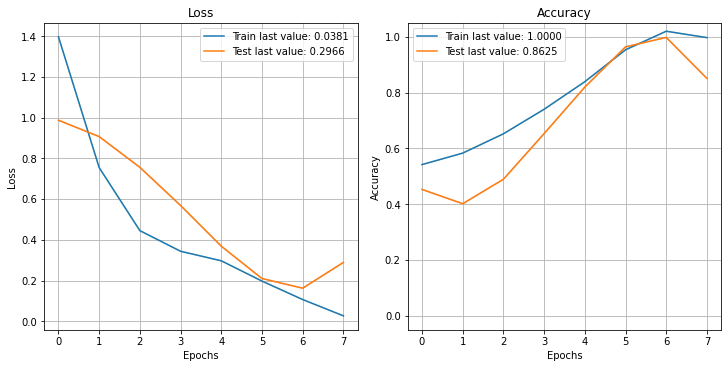

In [6]:
epoch_size = 2000
batch_size = 10

pred_model_mc = get_model(mc=True, 
                          num_of_class=3, 
                          dropout_size=0.09,
                          input_size=X.shape[1],
                          act="tanh")

pred_model_mc, history_mc = train_models_without_dropouts(pred_model_mc)

plot_history(history_mc.history, interpolate=True)
plt.show()

## Let's find the uncertainty values of the each test dataset

In [7]:
# Monte carlo predictions
mc_predictions = []
for i in tqdm(range(50)):
    y_p = pred_model_mc.predict(X_test, batch_size=2)
    mc_predictions.append(y_p)

max_means = []
preds = []
entropy_vals = []
std_vals = []
for idx in range(X_test.shape[0]):
    px = np.array([p[idx] for p in mc_predictions])
    #print(px.max(axis=1))
    preds.append(px.mean(axis=0).argmax())
    max_means.append(px.mean(axis=0).max())
    prob_dist = []
    for i, (prob, var) in enumerate(zip(px.mean(axis=0), px.std(axis=0))):
        prob_dist.append(prob)
    entropy_vals.append(shannon_entropy(prob_dist))
    #entropy_vals.append(entropy(prob_dist, base=2))
    std_vals.append(np.std(px.max(axis=1)))

unc_ent_idx = np.flip((np.array(entropy_vals)).argsort()[-3:])
unc_std_idx = np.flip((np.array(std_vals)).argsort()[0:3])

100%|██████████| 50/50 [15:58<00:00, 19.17s/it]


## Research Questions
We aim to explore uncertainty quantification using the Bayesian neural network with the entropy and Softmax prediction probability variance methods. So we form the following Research Questions (RQs) and design the experiments to answer them: 
- **RQ1** How can the model's decision making be characterized with uncertainty quantification?
- **RQ2** Is there any correlation between uncertainty and classification performance?
- **RQ3** How can the model's false labelling be predicted by another model using the uncertainty values?
- **RQ4** What is the best strategy for the best dropout ratio?

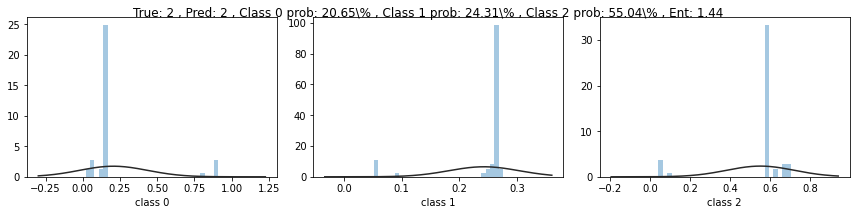

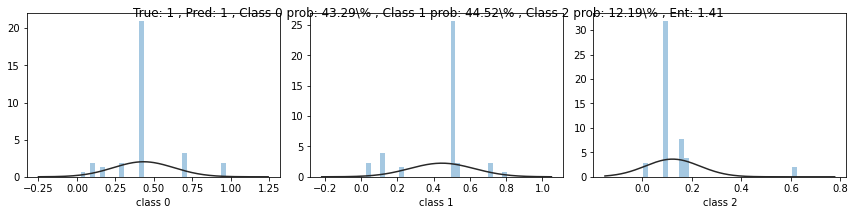

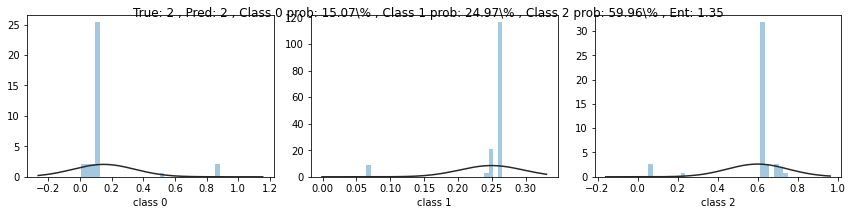

In [8]:
for idx_iter in range(3):
    idx = unc_ent_idx[idx_iter]
    p0 = np.array([p[idx] for p in mc_predictions])
    prob_txt = []
    prob_txt.append("True: {}".format(y_test[idx].argmax()))
    prob_txt.append(", Pred: {}".format(p0.mean(axis=0).argmax()))

    prob_dist = []

    for i, (prob, var) in enumerate(zip(p0.mean(axis=0), p0.std(axis=0))):
        prob_txt.append(", Class {} prob: {:2.2f}\%".format(i, prob*100))
        prob_dist.append(prob)
    prob_txt.append(", Ent: {:.2f}".format(shannon_entropy(prob_dist)))

    prob_txt = " ".join(prob_txt).strip()
    fig, axes = plt.subplots(1, 3, figsize=(12,3))

    for i, ax in enumerate(fig.get_axes()):
        sns.distplot( p0[:,i],ax=ax, bins=30, fit=norm, kde=False)
        ax.set_xlabel(f"class {i}")

    fig.suptitle(prob_txt)
    fig.tight_layout()
    
    plt.show()

## RQ2: Is there any correlation between uncertainty and classification performance?

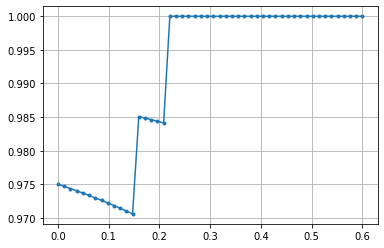

In [9]:
df_results = pd.DataFrame({'y':y_test.argmax(axis=1)})
df_results['y'] = y_test.argmax(axis=1)
df_results['y_hat'] = preds
df_results['unc_entropy'] = entropy_vals
df_results['unc_std'] = std_vals

discarded_ratio_list = np.linspace(0,0.6,num=50)

df_results.sort_values(by=['unc_entropy'],ascending=True,inplace=True)

acc_list = []
for discarded_ratio in discarded_ratio_list:
    tmp_df = df_results.head(np.int(df_results.shape[0] * (1-discarded_ratio)))
    y = tmp_df.y.values
    y_hat = tmp_df.y_hat.values
    acc_list.append(accuracy_score(y,y_hat))
plt.plot(discarded_ratio_list,acc_list, '-', marker = '.')
plt.grid()
plt.show()

In [10]:
cr = classification_report(df_results.y,df_results.y_hat)
print(cr)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        29
           1       1.00      0.91      0.95        23
           2       1.00      1.00      1.00        28

    accuracy                           0.97        80
   macro avg       0.98      0.97      0.97        80
weighted avg       0.98      0.97      0.97        80



## RQ3: How can the model's false labelling be predicted by another model using the uncertainty values?

wrong_labels [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]


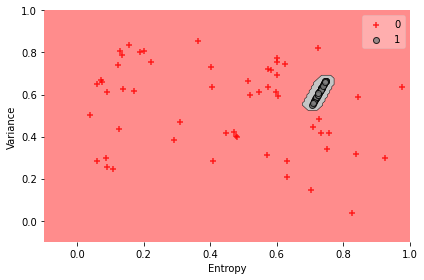

In [23]:
oversample = SMOTE(sampling_strategy='auto', random_state=10,k_neighbors=1)

X_unc = np.stack((entropy_vals,std_vals),axis=1)
scaler = MinMaxScaler()
X_unc = scaler.fit_transform(X_unc)

mc_ensemble_pred = np.array(mc_predictions).mean(axis=0).argmax(axis=1)
wrong_labels = np.abs(y_test.argmax(axis=1) - mc_ensemble_pred)
wrong_labels[np.where(wrong_labels > 0)] = 1
print('wrong_labels',wrong_labels)

#help(SMOTE)

X_unc, wrong_labels = oversample.fit_resample(X_unc, wrong_labels)
X_w_train, X_w_test, y_w_train, y_w_test = train_test_split(X_unc, wrong_labels, 
                                                    test_size=0.3)

X_w_train, y_w_train = oversample.fit_resample(X_w_train, y_w_train)

clf = SVC(gamma=1000,kernel='rbf',C=1000,tol=1e-14, max_iter=1e8)
clf.fit(X_w_train, y_w_train)

ax = plot_decision_regions(X_w_train, y_w_train, clf=clf, legend=1,
                      markers='+o',hide_spines=True,colors='red,gray')
plt.xlim((-0.1,1.0))
plt.ylim((-0.1,1.0))
plt.xlabel('Entropy')
plt.ylabel('Variance')
plt.tight_layout()
plt.show()

## RQ4: What is the best strategy for the best dropout ratio?

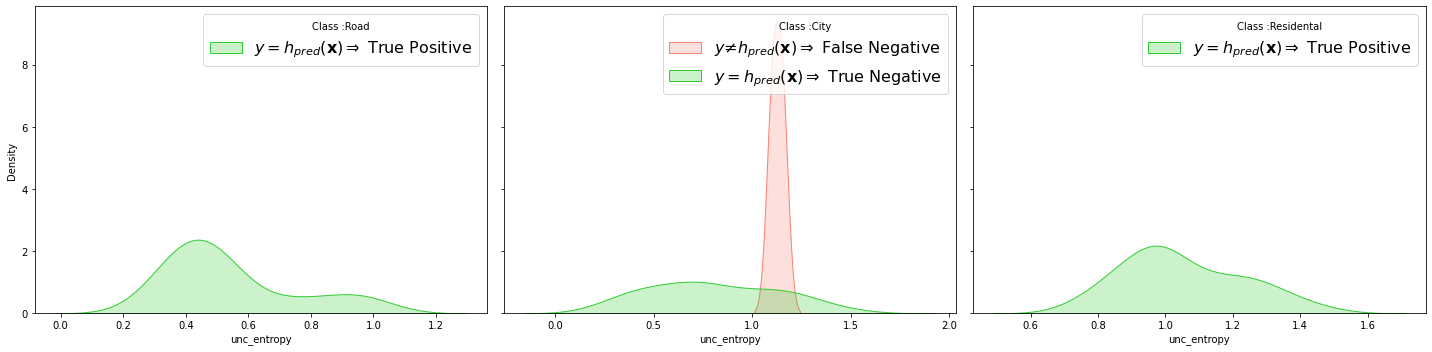

In [24]:
num_of_class = 3
class_names = ['Road', 'City', 'Residental']

fig, axes = plt.subplots(1, num_of_class, figsize=(20, 5), sharey=True)
for i in range(num_of_class):
    kde_plot_title = ' Positive'
    if i == 1:
        kde_plot_title = ' Negative'

    subset = df_results.query('y==' + str(i) + ' and y_hat!=' + str(i))
    sns.distplot(subset['unc_entropy'], hist = False, kde = True,
                 kde_kws = {'linewidth': 1, 'shade': True},ax=axes[i],
                 hist_kws=dict(alpha=1),color="salmon",
                 label = r'$y \ne h_{pred}(\mathbf{x}) \Rightarrow$ False' + kde_plot_title)
    
    subset = df_results.query('y==' + str(i) + ' and y_hat==' + str(i))
    sns.distplot( subset['unc_entropy'], hist = False, kde = True,
                 kde_kws = {'linewidth': 1, 'shade': True},ax=axes[i],
                 hist_kws=dict(alpha=1),color="limegreen",
                 label = '$y = h_{pred}(\mathbf{x}) \Rightarrow$ True' + kde_plot_title)
    axes[i].legend(prop={'size': 16}, 
                           title = 'Class :' + str(class_names[i]))
plt.tight_layout()
plt.show()